In [24]:
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from D_Age_Technologies import *

sns.set_style('darkgrid')
sns.set_palette('viridis')

DATA_PATH_2020 = './data/2020.csv'
DATA_PATH_2019 = './data/2019.csv'
DATA_PATH_2018 = './data/2018.csv'

df_2018 = pd.read_csv(DATA_PATH_2018)
df_2019 = pd.read_csv(DATA_PATH_2019)
df_2020 = pd.read_csv(DATA_PATH_2020)

company_type = 'Company type'
age = 'Age'
age_segment = 'age_segment'

def merge(data_frames, common_columns=[]):
    return pd.concat(data_frames, ignore_index=True)[common_columns]

def plt_cat_histogram(df, cat_colname, xlabel_rotation=90):
    col_counts = df[cat_colname].value_counts()
    sns.countplot(data=df, x=cat_colname, order=col_counts.index)
    plt.xticks(rotation=xlabel_rotation)
    plt.title(f'{cat_colname} Distribution')

def clean_company_types(df):
    for indx, row in df.iterrows():
        if row[company_type] is not None and type(row[company_type]) is not float:
            # remove leading and trailing spaces
            # change to lower case
            processed_value = row[company_type].strip().lower().replace("-", "")
            # normalize words by grouping those with same stem
            if ("consult" in processed_value):
                processed_value = 'consultancy'
            elif("research" in processed_value or "institut" in processed_value or "education" in processed_value):
                processed_value = 'research'
            elif ("commerc" in processed_value):
                processed_value = 'ecommerce'
            elif ("corporat" in processed_value):
                processed_value = 'corporate'
            elif ("outso" in processed_value): # most probably this is outsource but to also consider mis-spellings
                processed_value = 'outsource'
            
            # Map the responder's company type to coresponding more general company type
            if processed_value in company_type_mapping:
                processed_value = company_type_mapping[processed_value]

            df.loc[indx, company_type] = processed_value
    return df

In [25]:
merged_df = merge(data_frames=[df_2018, df_2019, df_2020], common_columns=[age, company_type])
assert merged_df.shape[0] == df_2018.shape[0] + df_2019.shape[0] + df_2020.shape[0]

## Analysis Outlines
- Perform the analysis per each year (consider the factor of time)
- Univariate analysis: the distribution of company types (histogram)
- Bivariate analysis: relation between the age and the company types (box plot)
- Hypothesis testing: joining a company type depends on the age

### Univariate Analysis on Company Type

In [3]:
print("Before Cleaning")
print("Number of unique company types for 2018 responders", len(df_2018[company_type].unique()))
print("Number of unique company types for 2019 responders", len(df_2019[company_type].unique()))
print("Number of unique company types for 2020 responders", len(df_2020[company_type].unique()))
print("Total Number of unique company types", len(merged_df[company_type].unique()))

Before Cleaning
Number of unique company types for 2018 responders 50
Number of unique company types for 2019 responders 8
Number of unique company types for 2020 responders 64
Total Number of unique company types 102


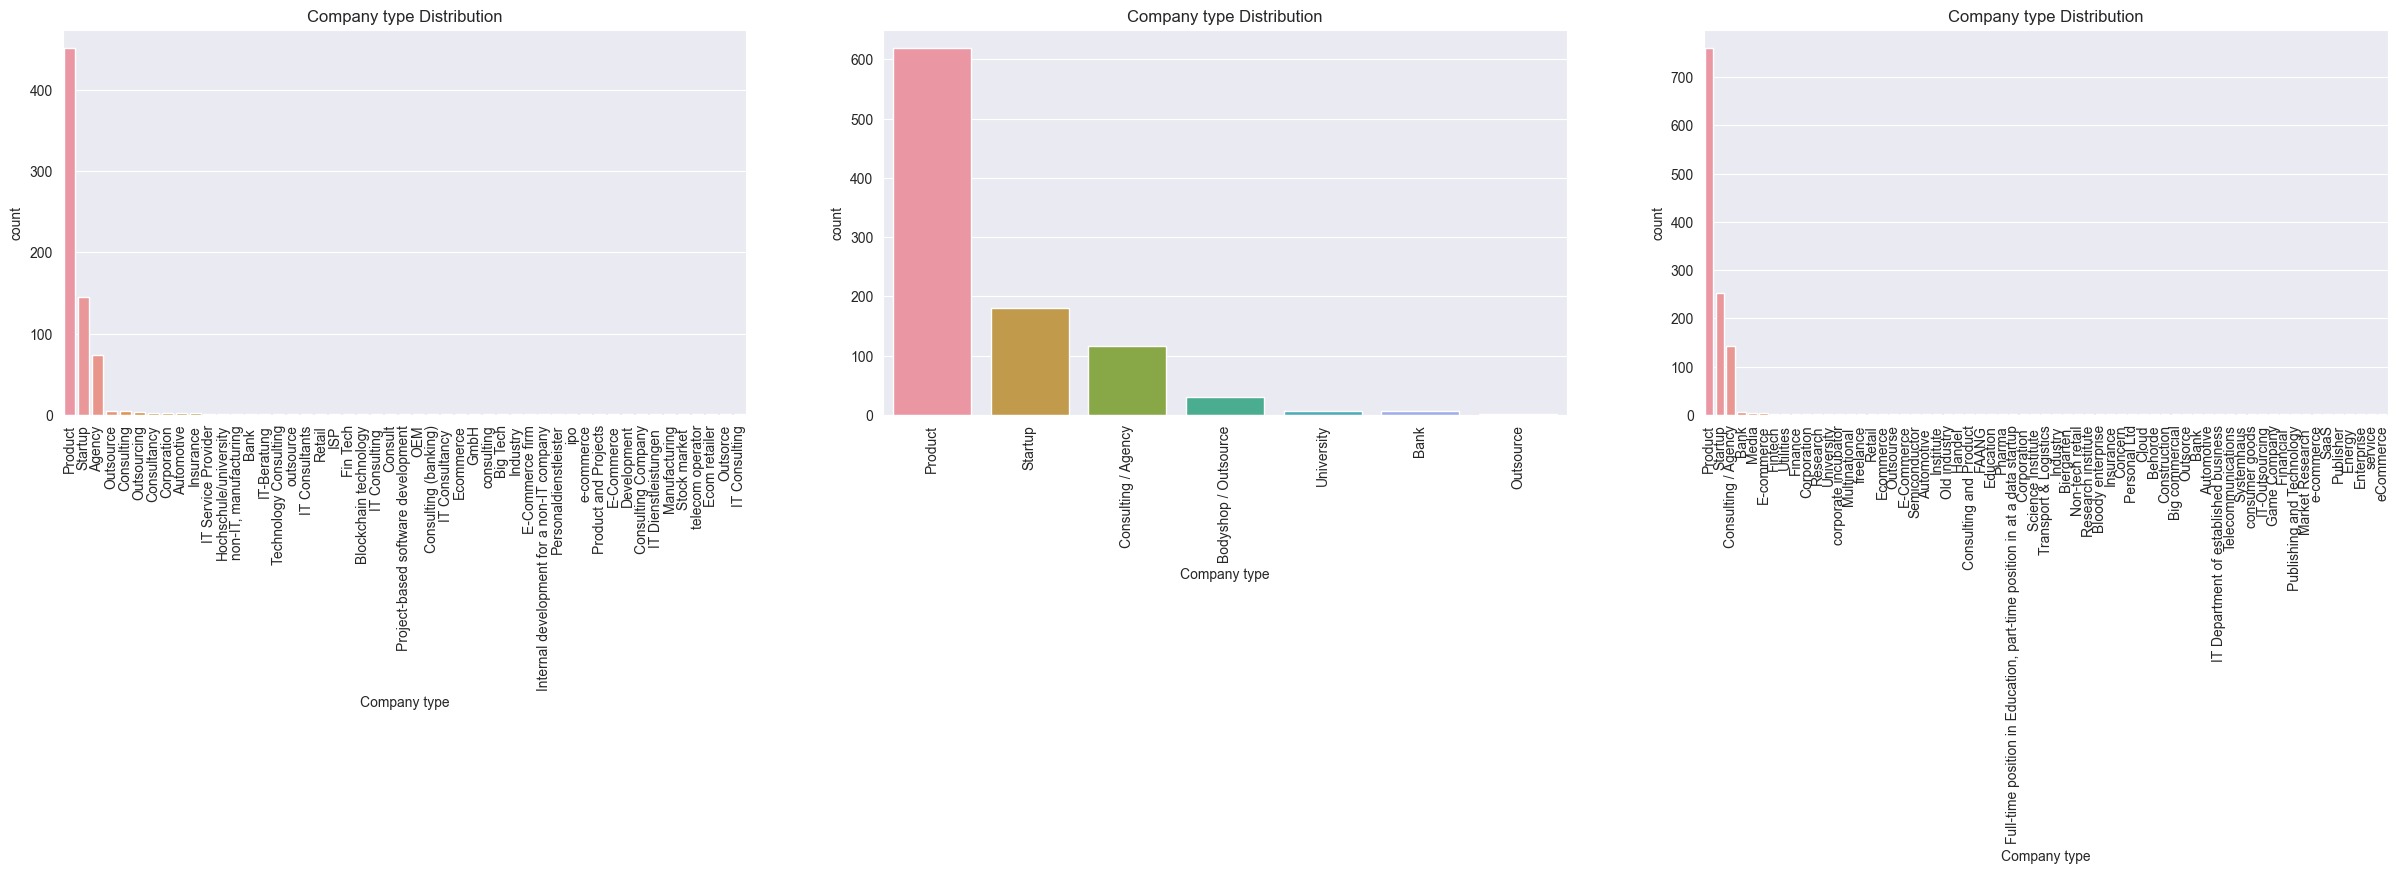

In [4]:
plt.figure(figsize=(30, 5))
plt.subplot(1, 3, 1)
plt_cat_histogram(df_2018, company_type)
plt.subplot(1, 3, 2)
plt_cat_histogram(df_2019, company_type)
plt.subplot(1, 3, 3)
plt_cat_histogram(df_2020, company_type)
plt.show()

It's shown that the most frequent company types are being almost the same across the 2018, 2019, and 2020 datasets.

#### Normalizing and Enforcing Consistency on Compnay Type

In [26]:
print("Before Normalizing, Number of unique types", len(merged_df[company_type].unique()))
cleaned_df = clean_company_types(merged_df.copy())
print("After Normalizing, Number of unique types", len(cleaned_df[company_type].unique()))

Before Normalizing, Number of unique types 102
After Normalizing, Number of unique types 40


In [28]:
cleaned_df[company_type].value_counts()

product                                     1830
startup                                      578
consultancy                                  276
agency                                        74
outsource                                     44
Financial/Insurance                           24
University/Research                           18
Manufacturing/Industry                        15
ecommerce                                     13
corporate                                     10
Media/Publishing                               5
Telecom/Communication                          3
retail                                         2
saas                                           1
consumer goods                                 1
game company                                   1
handel                                         1
bloody enterprise                              1
service                                        1
concern                                        1
it department of est

In [6]:
print("Before filtering out rows with low type frequency")
print("Number of unique types", len(cleaned_df[company_type].unique()))
print("# rows", cleaned_df.shape[0])

type_counts = cleaned_df[company_type].value_counts()
type_counts = type_counts[type_counts >= 10]
cleaned_df = cleaned_df[cleaned_df[company_type].isin(type_counts.index)]

print("After filtering out rows with low type frequency")
print("Number of unique types", len(cleaned_df[company_type].unique()))
print("# rows", cleaned_df.shape[0])


Before filtering out rows with low type frequency
Number of unique types 40
# rows 3009
After filtering out rows with low type frequency
Number of unique types 10
# rows 2882


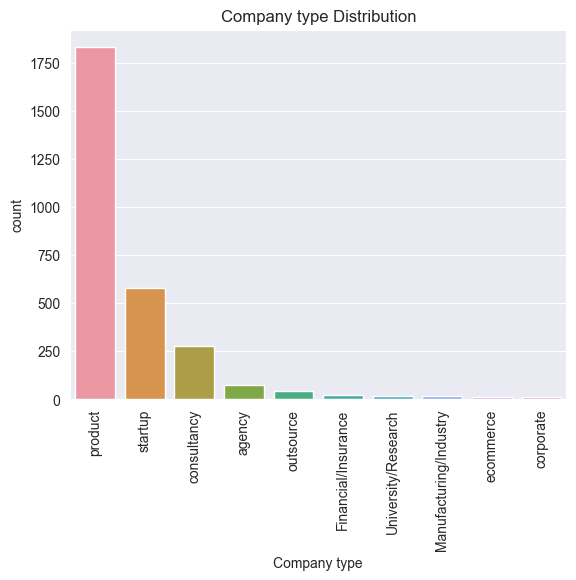

In [7]:
plt_cat_histogram(cleaned_df, company_type)

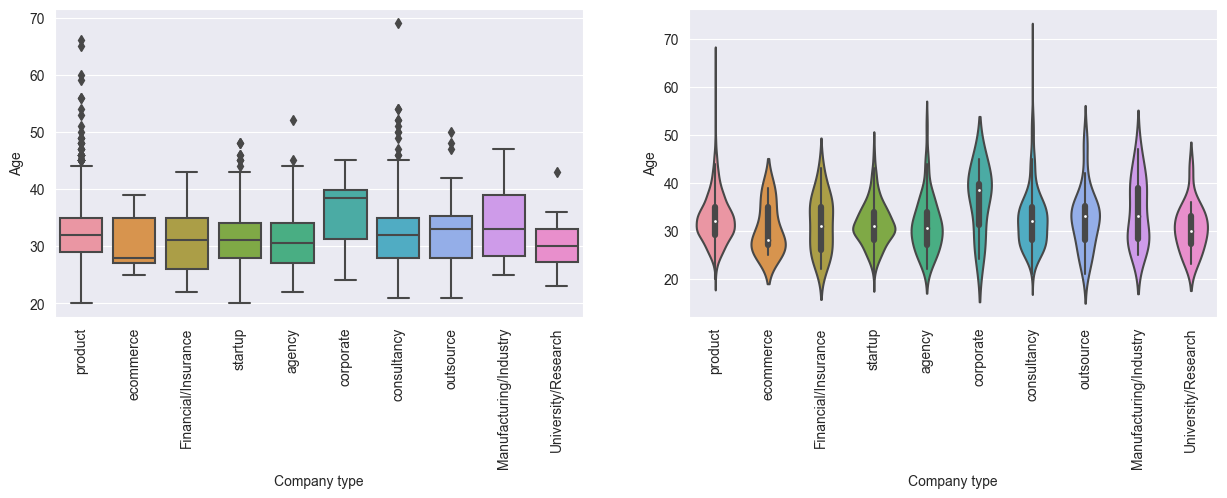

In [8]:
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
sns.boxplot(x=company_type, y=age, data=cleaned_df)
plt.xticks(rotation=90)

plt.subplot(1,2,2)
sns.violinplot(x=company_type, y=age, data=cleaned_df)
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Categorize age into age bins
cleaned_df = segment_age(cleaned_df)

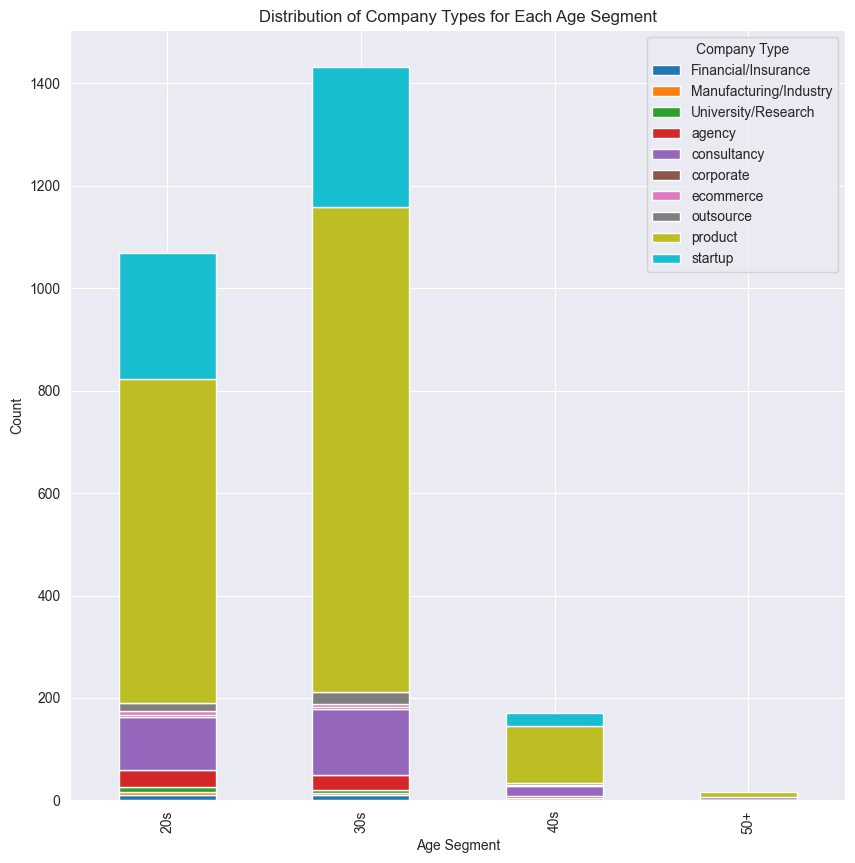

In [23]:
segment_counts = cleaned_df.groupby([age_segment, company_type]).size().unstack()
segment_counts.plot(kind='bar', stacked=True, figsize=(10, 10), colormap='tab10')
plt.xlabel('Age Segment')
plt.ylabel('Count')
plt.title('Distribution of Company Types for Each Age Segment')
plt.legend(title='Company Type')
plt.show()